In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import audio_tagging_utils as utils
import matplotlib.pyplot as plt

In [2]:
# Importing Keras and other pre-processing libraries
import tensorflow as tf
from tensorflow.python.client import device_lib
import tensorflow.keras.backend as K
import gc

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1791270960012572610
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1422504755
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11904160320885572685
physical_device_desc: "device: 0, name: GeForce GTX 960, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


Now we will transform each .wav file from the training and test sets to a corresponding spectogram.


In [ ]:
utils.create_images_no_prepro('train', 'train_no_preprocessing')

In [ ]:
utils.create_images_no_prepro('test', 'test_no_preprocessing')

Now It is time to build our predictive heart, a Convolutional Neural Network.

In [3]:
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.python.keras.engine import training
from tensorflow.python.framework.ops import Tensor
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, LeakyReLU, Conv2D, MaxPooling2D, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential, Model

def spectrogram_2d_conv_pool_cnn(model_input: Tensor) -> training.Model:
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(model_input)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.5)(x)
    
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.5)(x)
    
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(41, activation='softmax')(x) #TO-FIX THIS

    model = Model(model_input, x, name='spectrogram_2d_conv_pool_cnn')
    
    return model

def kaggle_2d_conv_pool_cnn(model_input: Tensor) -> training.Model:
    x = Conv2D(32, (4,10), padding="same")(model_input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dense(41, activation='softmax')(x) # TO-FIX THIS
    
    model = Model(model_input, x, name='kaggle_2d_conv_pool_cnn')
    
    return model

def kaggle_1d_conv_pool_cnn(model_input: Tensor) -> training.Model:
    x = Conv1D(16, 9, activation='relu', padding="valid")(model_input)
    x = Conv1D(16, 9, activation='relu', padding="valid")(x)
    x = MaxPooling1D(16)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Conv1D(32, 3, activation='relu', padding="valid")(x)
    x = Conv1D(32, 3, activation='relu', padding="valid")(x)
    x = MaxPooling1D(4)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Conv1D(32, 3, activation='relu', padding="valid")(x)
    x = Conv1D(32, 3, activation='relu', padding="valid")(x)
    x = MaxPooling1D(4)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Conv1D(256, 3, activation='relu', padding="valid")(x)
    x = Conv1D(256, 3, activation='relu', padding="valid")(x)
    x = GlobalMaxPooling1D()(x)
    x = Dropout(rate=0.2)(x)

    x = Dense(64, activation='relu')(x)
    x = Dense(1028, activation='relu')(x)
    x = Dense(41, activation='softmax')(x)
    
    model = Model(model_input, x, name='kaggle_1d_conv_pool_cnn')
    
    return model


def cnn_lstm(model_input: Tensor) -> training.Model:
    x = LSTM(512, activation='relu')(model_input) # TO-FIX THIS
    x = Dense(64, activation='relu')(x) # TO-FIX THIS
    x = Dense(41, activation='softmax')(x) # TO-FIX THIS
    
    model = Model(model_input, x, name='lstm')
    
    return model

Training our CNN that uses the .wav spectrograms as inputs files.

In [4]:
from tensorflow.keras.layers import Input

number_of_splits = 5

model_input = Input(shape=(64, 64, 3))
spectrogram_2d_conv_pool_cnn = spectrogram_2d_conv_pool_cnn(model_input)
spectrogram_2d_conv_pool_cnn.compile(optimizers.Adam(0.001),loss="categorical_crossentropy",metrics=['accuracy'])
spectrogram_2d_conv_pool_cnn.summary()

if not os.path.exists(f'runs\\{spectrogram_2d_conv_pool_cnn.name}'):
    os.mkdir(f'runs\\{spectrogram_2d_conv_pool_cnn.name}')
if os.path.exists(f'runs\\{spectrogram_2d_conv_pool_cnn.name}\\logs'):
    shutil.rmtree(f'runs\\{spectrogram_2d_conv_pool_cnn.name}\\logs')
    
traindf=pd.read_csv('meta\\train.csv')
testdf=pd.read_csv('meta\\test.csv')    
traindf["fname"]= traindf["fname"].apply(utils.append_ext)
testdf["fname"]= testdf["fname"].apply(utils.append_ext)

Model: "spectrogram_2d_conv_pool_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29

Found 7578 validated image filenames belonging to 41 classes.
Found 1895 validated image filenames belonging to 41 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 236 steps, validate for 59 steps
Epoch 1/50
235/236 [============================>.] - ETA: 0s - loss: 3.2205 - accuracy: 0.1244
Epoch 00001: val_loss improved from inf to 2.70920, saving model to runs\spectrogram_2d_conv_pool_cnn\best_0.h5
236/236 [==============================] - 20s 86ms/step - loss: 3.2202 - accuracy: 0.1247 - val_loss: 2.7092 - val_accuracy: 0.2357
Epoch 2/50
235/236 [============================>.] - ETA: 0s - loss: 2.4896 - accuracy: 0.2907
Epoch 00002: val_loss improved from 2.70920 to 2.13425, saving model to runs\spectrogram_2d_conv_pool_cnn\best_0.h5
236/236 [==============================] - 13s 53ms/step - loss: 2.4885 - accuracy: 0.2908 - val_loss: 2.1343 - val_accuracy: 0.3941
Epoch 3/50
235/236 [============================>.] - ETA: 0s - loss: 2.0751 - accuracy: 0.4088
E

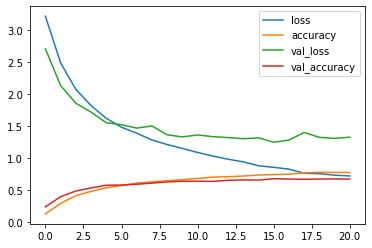

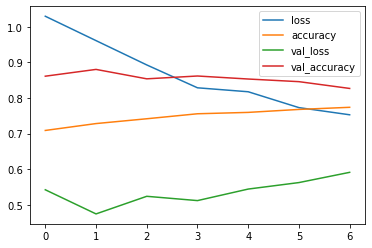

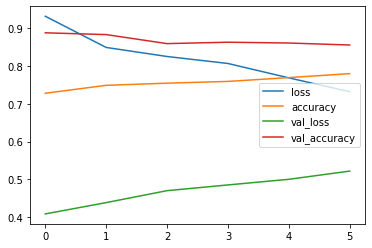

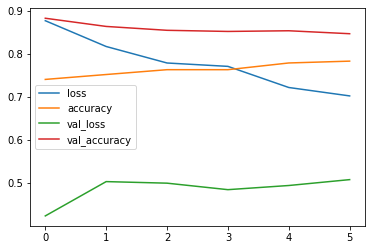

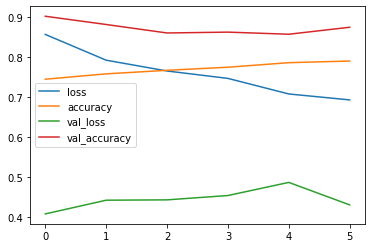

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Training con_pool_cnn

datagen=ImageDataGenerator(rescale=1./255.)
class_indices = {}

kfold_validation = KFold(n_splits= number_of_splits)

for i, (train_split_indexes, test_split_indexes) in enumerate(kfold_validation.split(traindf)):
    train_fold = traindf.iloc[train_split_indexes]
    val_fold = traindf.iloc[test_split_indexes]

    checkpoint = ModelCheckpoint(f'runs\\{spectrogram_2d_conv_pool_cnn.name}\\best_{i}.h5', monitor='val_loss', verbose=1, save_best_only=True)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    tb = TensorBoard(log_dir=f'runs\\{spectrogram_2d_conv_pool_cnn.name}\\logs\\fold_{i}', write_graph=True)

    callbacks_list = [checkpoint, early, tb]

    train_generator=datagen.flow_from_dataframe(
        dataframe=train_fold,
        directory="images\\train_no_preprocessing\\",
        x_col="fname",
        y_col="label",
        batch_size=32,
        seed=42,
        shuffle=True,
        class_mode="categorical",
        target_size=(64,64))

    valid_generator=datagen.flow_from_dataframe(
        dataframe=val_fold,
        directory="images\\train_no_preprocessing\\",
        x_col="fname",
        y_col="label",
        batch_size=32,
        seed=42,
        shuffle=True,
        class_mode="categorical",
        target_size=(64,64))

    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

    spectrogram_2d_conv_pool_cnn.fit(train_generator,
                    callbacks=callbacks_list,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50)

    spectrogram_2d_conv_pool_cnn.load_weights(f'runs\\{spectrogram_2d_conv_pool_cnn.name}\\best_{i}.h5')
    
    train_generator.reset()
    valid_generator.reset()
    
    eval_generator=datagen.flow_from_dataframe(
        dataframe=testdf,
        directory="images\\test_no_preprocessing\\",
        x_col="fname",
        y_col= "label",
        batch_size=32,
        seed=42,
        shuffle=False,
        class_mode="categorical",
        target_size=(64,64))

    STEP_SIZE_EVAL=eval_generator.n//eval_generator.batch_size

    eval_generator.reset()
    
    spectrogram_2d_conv_pool_cnn.evaluate(eval_generator, steps=STEP_SIZE_EVAL, verbose= 1)
    
    test_generator=datagen.flow_from_dataframe(
        dataframe=testdf,
        directory="images\\test_no_preprocessing\\",
        x_col="fname",
        y_col= None,
        batch_size=32,
        seed=42,
        shuffle=False,
        class_mode= None,
        target_size=(64,64))
    
    STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
    
    test_generator.reset()
    
    pred = spectrogram_2d_conv_pool_cnn.predict(test_generator, steps=STEP_SIZE_TEST, verbose= 1)

    np.save(f'runs\\{spectrogram_2d_conv_pool_cnn.name}\\test_predictions_{i}.npy', pred)
    
    pd.DataFrame(spectrogram_2d_conv_pool_cnn.history.history).plot()
    
    #On last step, retrieve actual class_indices, this is used to retrieve the actual string labels
    if i == number_of_splits - 1:
        class_indices = train_generator.class_indices

In [6]:
from sklearn import metrics

pred_list = []
for i in range(number_of_splits):
    pred_list.append(np.load(f'runs\\{spectrogram_2d_conv_pool_cnn.name}\\test_predictions_{i}.npy'))

prediction = np.ones_like(pred_list[0])

for pred in pred_list:
    prediction = prediction*pred
prediction = prediction**(1./len(pred_list))
# Make a submission file

predicted_class_indices = np.argmax(prediction,axis=-1)

labels = dict((v,k) for k,v in class_indices.items())
predicted_labels = [labels[k] for k in predicted_class_indices]

test = pd.read_csv('meta\\test.csv')
test[['fname', 'label']].to_csv(f'runs\\{spectrogram_2d_conv_pool_cnn.name}\\{spectrogram_2d_conv_pool_cnn.name}_predictions.csv', index=False)

y_true = test['label']
y_pred = predicted_labels

print(metrics.classification_report(y_true, y_pred, digits=3))

                       precision    recall  f1-score   support

      Acoustic_guitar      0.805     0.733     0.767        45
             Applause      0.833     0.938     0.882        32
                 Bark      0.742     0.821     0.780        28
            Bass_drum      0.893     0.893     0.893        28
Burping_or_eructation      0.969     0.969     0.969        32
                  Bus      0.737     0.560     0.636        25
                Cello      0.913     0.778     0.840        54
                Chime      0.750     0.724     0.737        29
             Clarinet      0.839     0.839     0.839        56
    Computer_keyboard      0.583     0.269     0.368        26
                Cough      0.714     0.833     0.769        30
              Cowbell      0.932     0.976     0.953        42
          Double_bass      0.704     0.950     0.809        40
 Drawer_open_or_close      0.818     0.621     0.706        29
       Electric_piano      0.958     0.719     0.821  

Now we will train a different model that uses raw mfcc obtained from the .wav files

In [7]:
max_len = 2
n_mfcc = 40
kaggle_2d_sr = 44100
kaggle_1d_sr = 16000

model_input = Input(shape=utils.mfcc_input_sizes(n_mfcc, kaggle_2d_sr, max_len))
kaggle_2d_conv_pool_cnn = kaggle_2d_conv_pool_cnn(model_input) 
kaggle_2d_conv_pool_cnn.compile(optimizers.Adam(0.001),loss="categorical_crossentropy",metrics=['accuracy'])

model_input = Input(shape=utils.wav_input_sizes(kaggle_1d_sr, max_len))
kaggle_1d_conv_pool_cnn = kaggle_1d_conv_pool_cnn(model_input) 
kaggle_1d_conv_pool_cnn.compile(optimizers.Adam(0.0001),loss="categorical_crossentropy",metrics=['accuracy'])

#kaggle_2d_conv_pool_cnn.summary()

if not os.path.exists(f'runs\\{kaggle_1d_conv_pool_cnn.name}'):
    os.mkdir(f'runs\\{kaggle_1d_conv_pool_cnn.name}')
if os.path.exists(f'runs\\{kaggle_1d_conv_pool_cnn.name}\\logs'):
    shutil.rmtree(f'runs\\{kaggle_1d_conv_pool_cnn.name}\\logs')

if not os.path.exists(f'runs\\{kaggle_2d_conv_pool_cnn.name}'):
    os.mkdir(f'runs\\{kaggle_2d_conv_pool_cnn.name}')
if os.path.exists(f'runs\\{kaggle_2d_conv_pool_cnn.name}\\logs'):
    shutil.rmtree(f'runs\\{kaggle_2d_conv_pool_cnn.name}\\logs')
    
models_to_train = [kaggle_2d_conv_pool_cnn, kaggle_1d_conv_pool_cnn]

traindf=pd.read_csv('meta\\train.csv')
testdf=pd.read_csv('meta\\test.csv')

+-----------Training kaggle_2d_conv_pool_cnn Model-----------+
Train on 7578 samples, validate on 1895 samples
Epoch 1/50
7520/7578 [============================>.] - ETA: 0s - loss: 2.8521 - accuracy: 0.2451 ETA: 0s - loss: 2.8617 - accuracy: 
Epoch 00001: val_loss improved from inf to 3.15297, saving model to runs\kaggle_2d_conv_pool_cnn\best_0.h5
7578/7578 [==============================] - 10s 1ms/sample - loss: 2.8501 - accuracy: 0.2451 - val_loss: 3.1530 - val_accuracy: 0.2095
Epoch 2/50
7520/7578 [============================>.] - ETA: 0s - loss: 2.1768 - accuracy: 0.4061
Epoch 00002: val_loss improved from 3.15297 to 2.14580, saving model to runs\kaggle_2d_conv_pool_cnn\best_0.h5
7578/7578 [==============================] - 8s 1ms/sample - loss: 2.1741 - accuracy: 0.4067 - val_loss: 2.1458 - val_accuracy: 0.4121
Epoch 3/50
7520/7578 [============================>.] - ETA: 0s - loss: 1.8753 - accuracy: 0.4918
Epoch 00003: val_loss improved from 2.14580 to 1.95381, saving model t

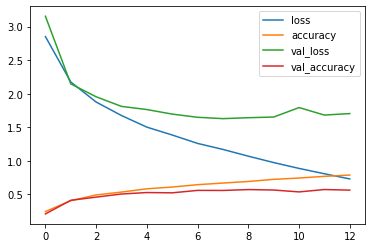

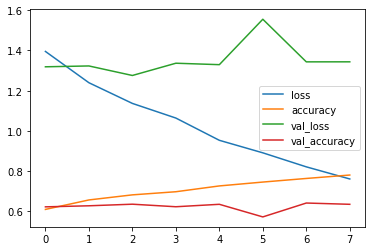

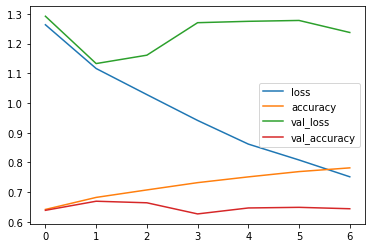

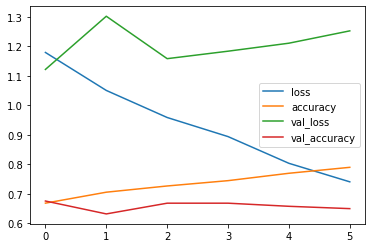

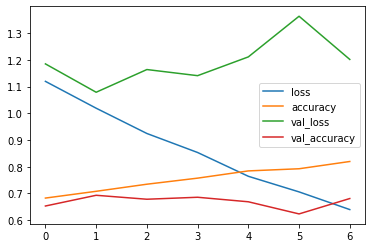

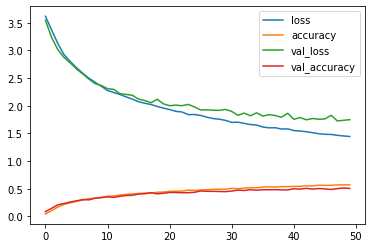

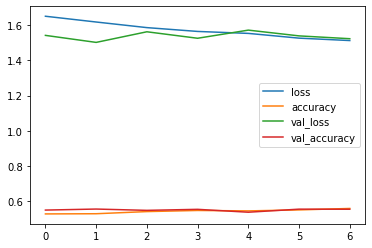

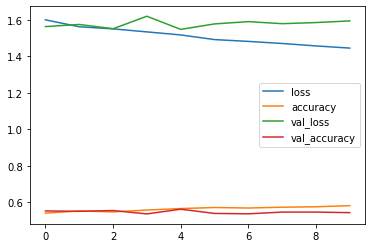

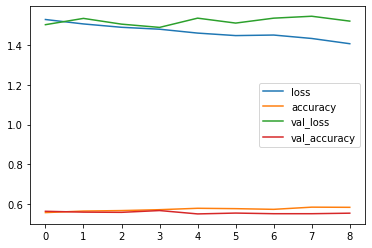

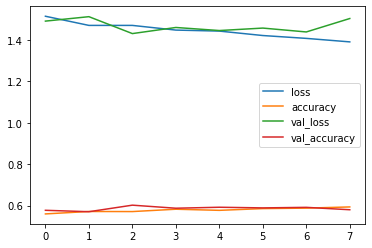

In [8]:
from tensorflow.keras.utils import to_categorical

kfold_validation = KFold(n_splits= number_of_splits)

for model in models_to_train:
    print(f'+-----------Training {model.name} Model-----------+')

    if not os.path.exists(f'runs\\{model.name}\\test_input_labels.npz') :
        if model.name == 'kaggle_2d_conv_pool_cnn':
            X_test, y_test = utils.create_mfcc_array(testdf, 'test', sr= kaggle_2d_sr, max_len= max_len, n_mfcc= n_mfcc)
        elif model.name == 'kaggle_1d_conv_pool_cnn':
            X_test, y_test = utils.create_wav_array(testdf, 'test', sr= kaggle_1d_sr, max_len= max_len)
        np.savez(f'runs\\{model.name}\\test_input_labels.npz', x_test=X_test, y_test=y_test)
    if os.path.exists(f'runs\\{model.name}\\test_input_labels.npz'):
        arr = np.load(f'runs\\{model.name}\\test_input_labels.npz')
        X_test, y_test = arr['x_test'], arr['y_test']
        
    if model.name == 'kaggle_2d_conv_pool_cnn':
        input_shape = utils.mfcc_input_sizes(n_mfcc, kaggle_2d_sr, max_len)
        X_test= X_test.reshape(X_test.shape[0], input_shape[0], input_shape[1], input_shape[2])#, input_shape[2])
    elif model.name == 'kaggle_1d_conv_pool_cnn':
        input_shape = utils.wav_input_sizes(kaggle_1d_sr, max_len)
        X_test= X_test.reshape(X_test.shape[0], input_shape[0], input_shape[1])#, input_shape[2])
    
    y_test_hot = to_categorical(pd.Series(y_test).apply(lambda x: class_indices[x]))
    
    mean = np.mean(X_test, axis=0)
    std = np.std(X_test, axis=0)
        
    X_test = (X_test - mean)/std
    
    for i, (train_split_indexes, test_split_indexes) in enumerate(kfold_validation.split(traindf)):
        train_fold = traindf.iloc[train_split_indexes]
        val_fold = traindf.iloc[test_split_indexes]
        
        if not os.path.exists(f'runs\\{model.name}\\fold{i}_len{max_len}_input_labels.npz'):
            if model.name == 'kaggle_2d_conv_pool_cnn':
                X_train, y_train = utils.create_mfcc_array(train_fold, 'train', sr= kaggle_2d_sr, max_len= max_len, n_mfcc= n_mfcc)
                X_val, y_val = utils.create_mfcc_array(val_fold, 'train', sr= kaggle_2d_sr, max_len= max_len, n_mfcc= n_mfcc)
            elif model.name == 'kaggle_1d_conv_pool_cnn':
                X_train, y_train = utils.create_wav_array(train_fold, 'train', sr= kaggle_1d_sr, max_len= max_len)
                X_val, y_val = utils.create_wav_array(val_fold, 'train', sr= kaggle_1d_sr, max_len= max_len)
            
            np.savez(f'runs\\{model.name}\\fold{i}_len{max_len}_input_labels.npz', x_train=X_train, y_train=y_train, x_val=X_val, y_val=y_val)
        if os.path.exists(f'runs\\{model.name}\\fold{i}_len{max_len}_input_labels.npz'):
            arr = np.load(f'runs\\{model.name}\\fold{i}_len{max_len}_input_labels.npz')
            X_train, y_train = arr['x_train'], arr['y_train']
            X_val, y_val = arr['x_val'], arr['y_val']
        
        checkpoint = ModelCheckpoint(f'runs\\{model.name}\\best_{i}.h5', monitor='val_loss', verbose=1, save_best_only=True)
        early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
        tb = TensorBoard(log_dir=f'runs\\{model.name}\\logs\\fold_{i}', write_graph=True)
    
        callbacks_list = [checkpoint, early, tb]
    
        y_train, y_val = pd.Series(y_train).apply(lambda x: class_indices[x]), pd.Series(y_val).apply(lambda x: class_indices[x])
        
        if model.name == 'kaggle_2d_conv_pool_cnn':
            X_train, X_val = X_train.reshape(X_train.shape[0], input_shape[0], input_shape[1], input_shape[2]), X_val.reshape(X_val.shape[0], input_shape[0], input_shape[1], input_shape[2])
        elif model.name == 'kaggle_1d_conv_pool_cnn':
            X_train, X_val = X_train.reshape(X_train.shape[0], input_shape[0], input_shape[1]), X_val.reshape(X_val.shape[0], input_shape[0], input_shape[1])
        
        mean = np.mean(X_train, axis=0)
        std = np.std(X_train, axis=0)
        
        X_train, X_val = (X_train - mean)/std, (X_val - mean)/std
        
        y_train_hot = to_categorical(y_train)
        y_val_hot = to_categorical(y_val)  
        
        model.fit(X_train, y_train_hot,
                    callbacks=callbacks_list,
                    validation_data=(X_val, y_val_hot),
                    shuffle=True,
                    epochs=50)
        
        model.load_weights(f'runs\\{model.name}\\best_{i}.h5')
        
        model.evaluate(X_test, y_test_hot)
        
        pred = model.predict(X_test, verbose= 1)
    
        np.save(f'runs\\{model.name}\\test_predictions_{i}.npy', pred)
        
        pd.DataFrame(model.history.history).plot()

In [9]:
for model in models_to_train:
    pred_list = []
    for i in range(number_of_splits):
        pred_list.append(np.load(f'runs\\{model.name}\\test_predictions_{i}.npy'))
    
    prediction = np.ones_like(pred_list[0])
    
    for pred in pred_list:
        prediction = prediction*pred
    prediction = prediction**(1./len(pred_list))
    # Make a submission file
    
    predicted_class_indices = np.argmax(prediction,axis=-1)
    
    labels = dict((v,k) for k,v in class_indices.items())
    predicted_labels = [labels[k] for k in predicted_class_indices]
    
    test = pd.read_csv('meta\\test.csv')
    test[['fname', 'label']].to_csv(f'runs\\{model.name}\\{model.name}_predictions.csv', index=False)
    
    y_true = test['label']
    y_pred = predicted_labels
    
    print(f'+-----------Printing {model.name} predictions evaluation-----------+')
    print(metrics.classification_report(y_true, y_pred, digits=3))

+-----------Printing kaggle_2d_conv_pool_cnn predictions evaluation-----------+
                       precision    recall  f1-score   support

      Acoustic_guitar      0.510     0.578     0.542        45
             Applause      0.780     1.000     0.877        32
                 Bark      0.731     0.679     0.704        28
            Bass_drum      0.686     0.857     0.762        28
Burping_or_eructation      0.588     0.938     0.723        32
                  Bus      0.857     0.480     0.615        25
                Cello      0.627     0.870     0.729        54
                Chime      0.609     0.483     0.538        29
             Clarinet      0.803     0.875     0.838        56
    Computer_keyboard      0.857     0.231     0.364        26
                Cough      0.750     0.600     0.667        30
              Cowbell      0.851     0.952     0.899        42
          Double_bass      0.811     0.750     0.779        40
 Drawer_open_or_close      0.667     

Time to ensemple our predictions.

In [10]:
pred_list = []
for i in range(number_of_splits):
    pred_list.append(np.load(f'runs\\{spectrogram_2d_conv_pool_cnn.name}\\test_predictions_{i}.npy'))
    
for model in models_to_train:
    for i in range(number_of_splits):
        pred_list.append(np.load(f'runs\\{model.name}\\test_predictions_{i}.npy'))

prediction = np.ones_like(pred_list[0])

for pred in pred_list:
    prediction = prediction*pred
prediction = prediction**(1./len(pred_list))
# Make a submission file

predicted_class_indices = np.argmax(prediction,axis=-1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predicted_labels = [labels[k] for k in predicted_class_indices]

test = pd.read_csv('meta\\test.csv')
test[['fname', 'label']].to_csv(f'ensembled_predictions.csv', index=False)

y_true = test['label']
y_pred = predicted_labels

print(metrics.classification_report(y_true, y_pred, digits=3))

                       precision    recall  f1-score   support

      Acoustic_guitar      0.706     0.800     0.750        45
             Applause      0.886     0.969     0.925        32
                 Bark      0.812     0.929     0.867        28
            Bass_drum      0.806     0.893     0.847        28
Burping_or_eructation      0.914     1.000     0.955        32
                  Bus      0.895     0.680     0.773        25
                Cello      0.825     0.870     0.847        54
                Chime      0.760     0.655     0.704        29
             Clarinet      0.791     0.946     0.862        56
    Computer_keyboard      0.867     0.500     0.634        26
                Cough      0.897     0.867     0.881        30
              Cowbell      0.930     0.952     0.941        42
          Double_bass      0.878     0.900     0.889        40
 Drawer_open_or_close      0.818     0.621     0.706        29
       Electric_piano      0.923     0.750     0.828  